In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import textblob

import data
import plot

In [2]:
train, test = data.get_data(use_cached=True)

Using Cached


# Goals of Exploration
- Plot some conversation samples
- Observe and explore why 3 of the major changes in conversations happened?
    - Topics
    - Replies

In [3]:
def _clean(string):
    string = string.lower()
    return string

def word_tokenize(string):
    return string.split(' ')

## Taking a look at a few random conversations

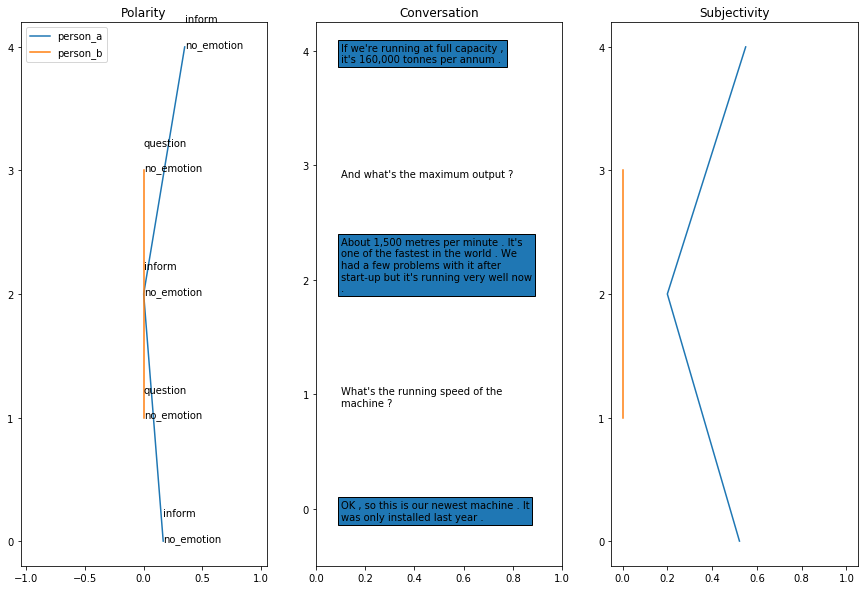

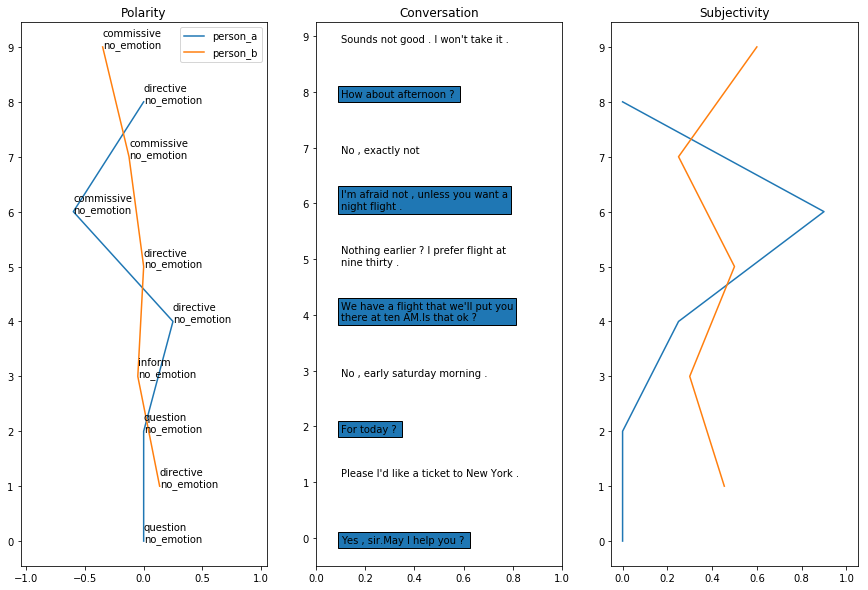

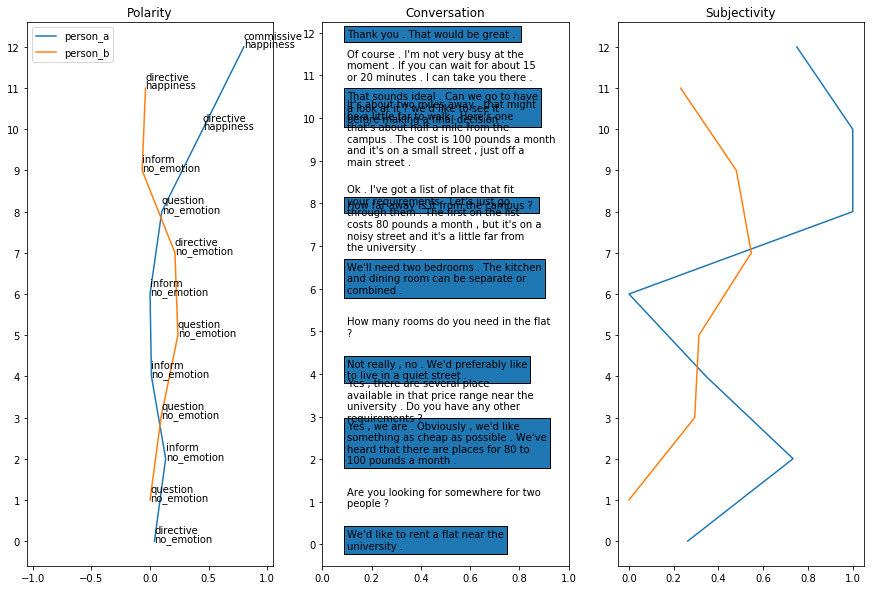

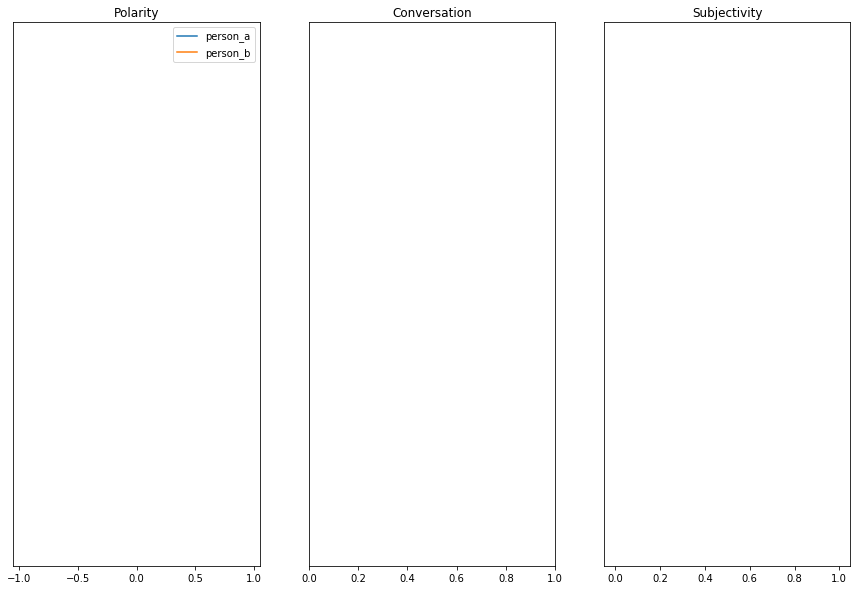

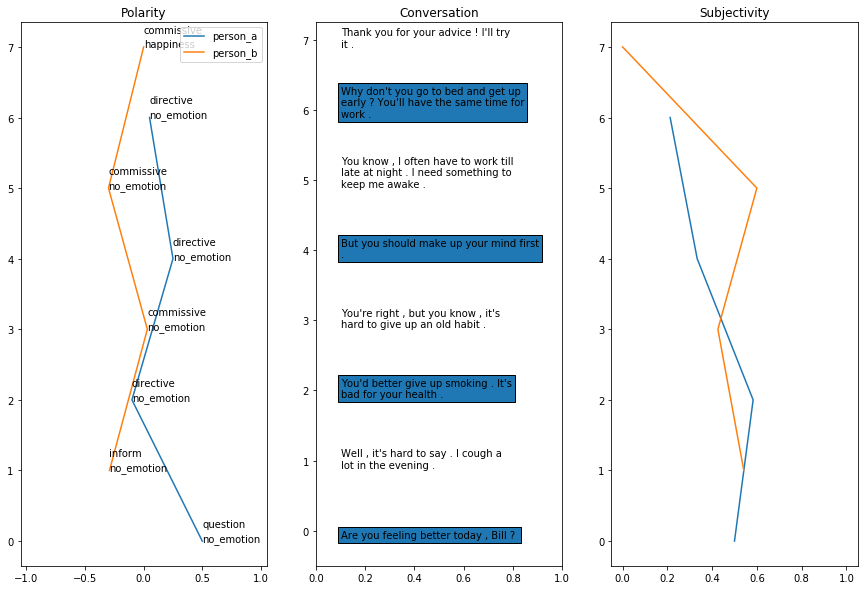

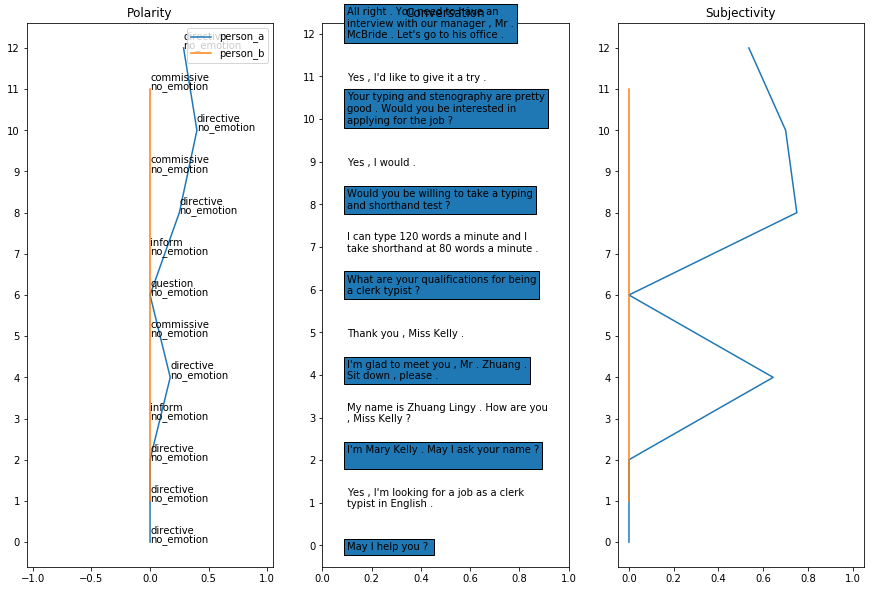

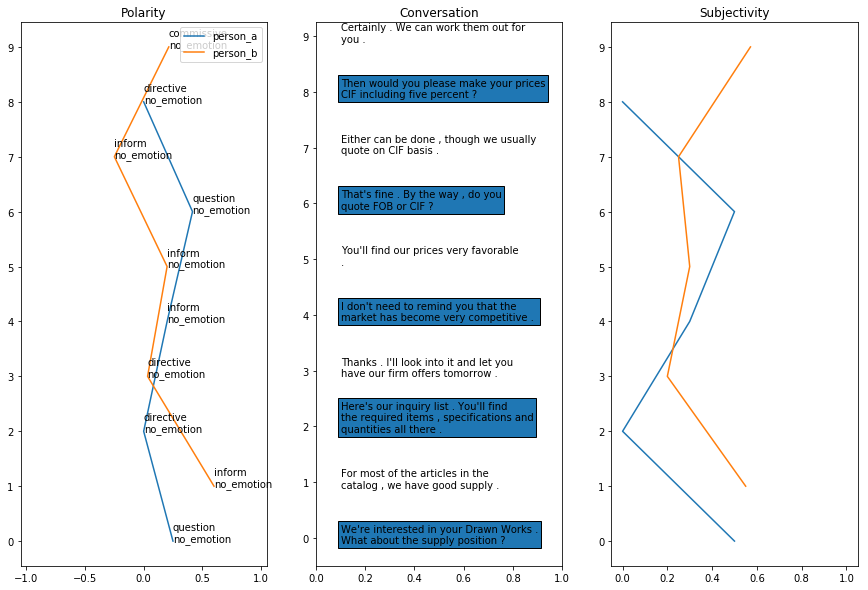

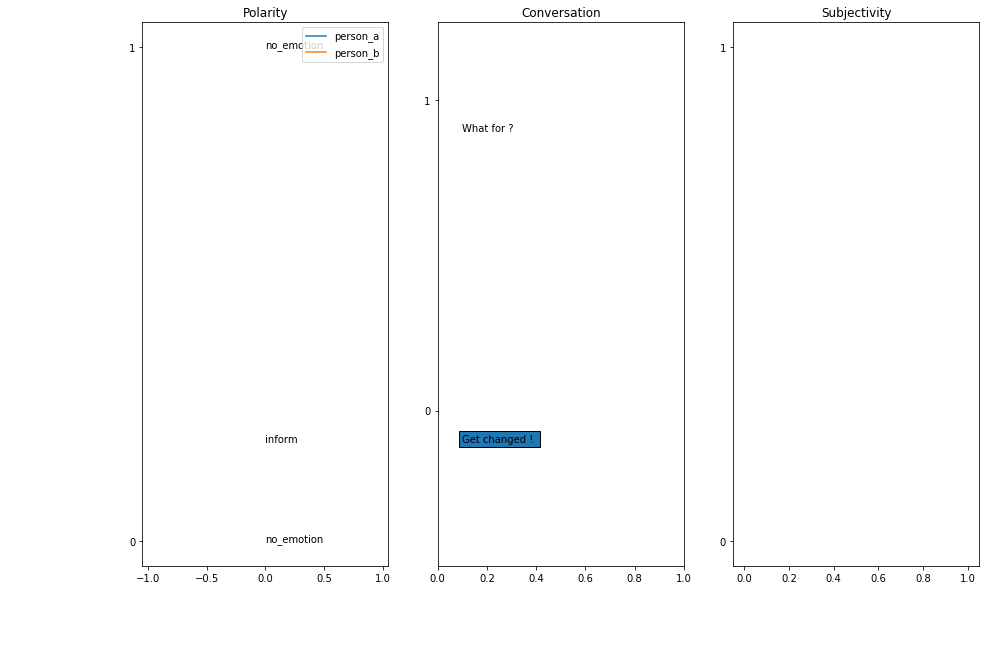

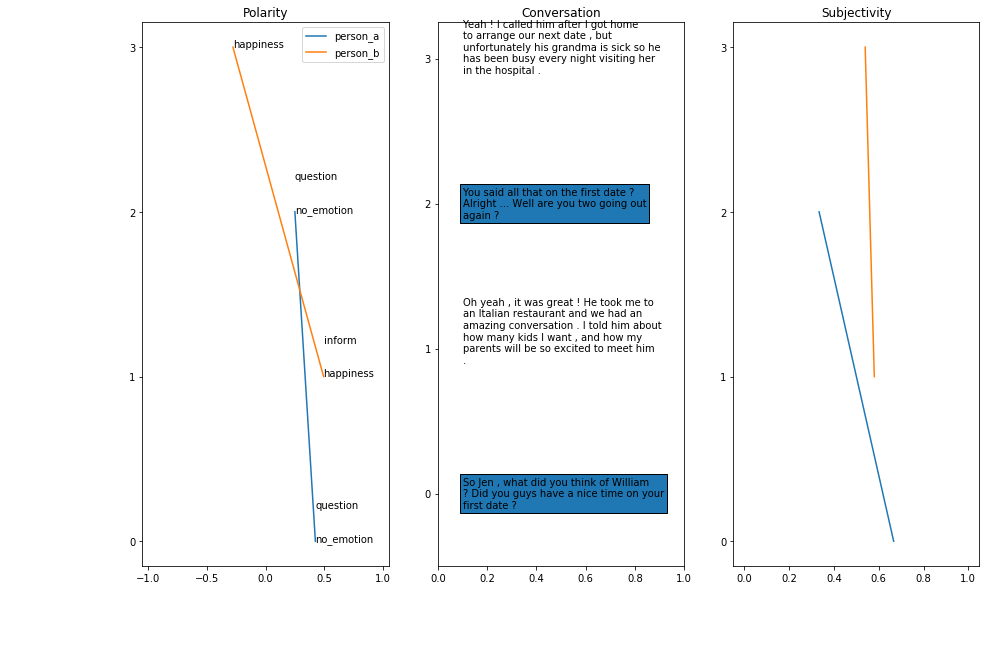

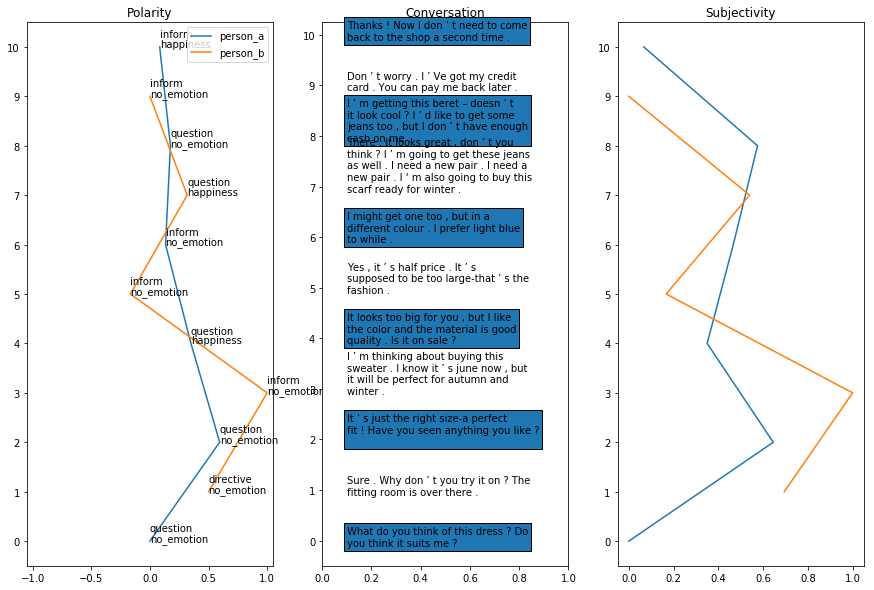

In [4]:
values = set(train.index.get_level_values(0))
num_convs = len(values)
conv_ids = np.random.randint(0, num_convs, 10)
for conv_id in conv_ids:
    plot.plot_conv(train.loc[conv_id])

## Looking at examples that had the largest change in sentiment

In [101]:
change_in_polarity = train.groupby([train.index.get_level_values(0), 'person'])['polarity'].diff()

In [108]:
train['change_in_polarity'] = change_in_polarity

In [109]:
train

person                                              utter  \
conv                                                                    
0     0   person_a                              The kitchen stinks .    
      1   person_b                      I'll throw out the garbage .    
1     0   person_a  So Dick , how about getting some coffee for to...   
      1   person_b   Coffee ? I don ’ t honestly like that kind of...   
      2   person_a   Come on , you can at least try a little , bes...   
      3   person_b   What ’ s wrong with that ? Cigarette is the t...   
      4   person_a                               Not for me , Dick .    
2     0   person_a  Are things still going badly with your housegu...   
      1   person_b   Getting worse . Now he ’ s eating me out of h...   
      2   person_a   Leo , I really think you ’ re beating around ...   
      3   person_b   You ’ re right . Everything is probably going...   
3     0   person_a                  Would you mind waiting a while ?    
      1   person_b                      Well , how long will it be ?    
      2   person_a   I'm not sure . But I'll get a table ready as ...   
      3   person_b                                 OK . We'll wait .    
4     0   person_a  Are you going to the annual party ? I can give...   
      1   person_b   Thanks a lot . That's the favor I was going t...   
      2   person_a                            The pleasure is mine .    
5     0   person_a  Isn ’ t he the best instructor ? I think he ’ ...   
      1   person_b      I swear , I ’ m going to kill you for this .    
      2   person_a   What ’ s wrong ? Didn ’ t you think it was fu...   
      3   person_b   Oh , yeah ! I had a blast ! I love sweating l...   
      4   person_a   Oh , no , get off it . It wasn ’ t such a kil...   
      5   person_b                      I am wiped out . Thank you .    
      6   person_a   Look , next time get yourself some comfy shoe...   
      7   person_b           Never ! But thank you for inviting me .    
      8   person_a   Come on . You ’ ll feel better after we hit t...   
6     0   person_a  Can I take your order now or do you still want...   
      1   person_b   Well , I want a fillet steak , medium , but m...   
      2   person_a   Certainly . How about spaghetti with clams an...   
...            ...                                                ...   
13116 2   person_a         have you filled out an application form ?    
      3   person_b   yes . And I've brought some documents along w...   
      4   person_a   yes . I'll just have my assistant look over t...   
      5   person_b   yes . Does the checking account come with a d...   
      6   person_a   yes . Actually , both accounts come with card...   
      7   person_b                          that's very convenient .    
      8   person_a   it is . Our customers really like it . Do you...   
      9   person_b   yes . What's the maximum amount that you are ...   
      10  person_a                           the maximum is $ 1000 .    
      11  person_b      is there a penalty for having an overdraft ?    
      12  person_a   yes , but it's not much . You just have to pa...   
      13  person_b   that's true . Is everything alright with my d...   
      14  person_a   they're all in order . If you just sign your ...   
      15  person_b                             thank you very much .    
      16  person_a                                  you're welcome .    
13117 0   person_a   May I ask you a few questions about insurance ?    
      1   person_b                                             Yes .    
      2   person_a   Now we've given a CIF Shanghai price for some...   
      3   person_b   Well . Obviously , you won ’ t want All Risks...   
      4   person_a                                         Why not ?    
      5   person_b   Because they aren ’ t delicate goods and won ...   
      6   person_a   Then am I right in understanding that FPA doe... 

# Archived notes

### The parser suggested by Loris was not random if you look at the topic distribution

Just taking a brief look at the topic distribution. It appears that it's not even for each test set. 

In [3]:
train['topic'].unique(), validation['topic'].unique(), test['topic'].unique()

(array(['ordinary_life', 'school_life', 'culture_education',
        'attitude_emotion', 'relationship', 'tourism', 'health', 'work'],
       dtype=object),
 array(['work'], dtype=object),
 array(['work', 'politics', 'finance'], dtype=object))

Yeah the original dataset is simply sorted topics. I can't trust the topics. Not only that, they aren't really meaningful from one dataset to the next.

In [4]:
topics = pd.read_csv('data/ijcnlp_dailydialog/dialogues_topic.txt') # original unparsed
topics = topics['1']

print('Train dataset unique: {}\n'.format(topics[0:11118].unique()))
print('Validation dataset unique: {}\n'.format(topics[11118:12118].unique()))
print('Test dataset unique: {}\n'.format(topics[12118: 13118].unique()))

Train dataset unique: [1 2 3 4 5 6 7 8]

Validation dataset unique: [8]

Test dataset unique: [ 8  9 10]



##### Not going to use Topics for now. 